# Identitas diri

Nama : Agung Prabowo 

Email : agungprabowo8800@gmail.com

Kota : Bekasi

Phone : 089696826119


# Tahap upload dataset

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2021-04-22 10:03:21--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  7.18MB/s    in 71s     

2021-04-22 10:04:33 (4.33 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



# split dataset menjadi train set 60% & validasi set 40%

In [3]:
import zipfile,os
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
 
base_dir = '/tmp/rockpaperscissors'
rock = os.path.join(base_dir, 'rock')
paper = os.path.join(base_dir, 'paper')
scissors = os.path.join(base_dir, 'scissors')
train = os.path.join(base_dir, 'train')
val = os.path.join(base_dir, 'val')
train_rock = os.path.join(base_dir, 'train/rock')
train_paper = os.path.join(base_dir, 'train/paper')
train_scissors = os.path.join(base_dir, 'train/scissors')
val_rock = os.path.join(base_dir, 'val/rock')
val_paper = os.path.join(base_dir, 'val/paper')
val_scissors = os.path.join(base_dir, 'val/scissors')

In [4]:
os.mkdir(train)
os.mkdir(val)
os.mkdir(train_rock)
os.mkdir(train_paper)
os.mkdir(train_scissors)
os.mkdir(val_rock)
os.mkdir(val_paper)
os.mkdir(val_scissors)

In [5]:
import random

image_rock = os.listdir(rock)
image_paper = os.listdir(paper)
image_scissors = os.listdir(scissors)

random.shuffle(image_rock)
random.shuffle(image_paper)
random.shuffle(image_scissors)

In [6]:
import shutil

train_set_rock = round(0.6*len(image_rock))
train_set_paper = round(0.6*len(image_paper))
train_set_scissors = round(0.6*len(image_scissors))

for x in image_rock[:train_set_rock]:
  shutil.copyfile(os.path.join(rock, x), os.path.join(train_rock, x))

for x in image_rock[train_set_rock:len(image_rock)]:
  shutil.copyfile(os.path.join(rock, x), os.path.join(val_rock, x))

for x in image_paper[:train_set_paper]:
  shutil.copyfile(os.path.join(paper, x), os.path.join(train_paper, x))

for x in image_paper[train_set_paper:len(image_paper)]:
  shutil.copyfile(os.path.join(paper, x), os.path.join(val_paper, x))

for x in image_scissors[:train_set_scissors]:
  shutil.copyfile(os.path.join(scissors, x), os.path.join(train_scissors, x))

for x in image_scissors[train_set_scissors:len(image_scissors)]:
  shutil.copyfile(os.path.join(scissors, x), os.path.join(val_scissors, x))

# inisialisasi callback

In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.96):
      print("\nReached 96% accuracy so cancelling training!")
      self.model.stop_training = True

# Augmentasi Image

In [8]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
val_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [10]:
train_generator = train_datagen.flow_from_directory(
        train,
        target_size=(150, 100),
        batch_size=20,
        class_mode='categorical')
 
val_generator = val_datagen.flow_from_directory(
        val, 
        target_size=(150, 100),
        batch_size=20,
        class_mode='categorical')

Found 1313 images belonging to 3 classes.
Found 875 images belonging to 3 classes.


# Model Machine learning dengan 4 convolitional dan 2 hidden layyer

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 100, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 98, 64)       1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 8, 128)        1

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [13]:
callbacks = myCallback()

iterate_model = model.fit(
      train_generator,
      steps_per_epoch=66, 
      epochs=20, 
      validation_data=val_generator, 
      validation_steps=44,  
      verbose=2,
      callbacks=[callbacks])

Epoch 1/20
66/66 - 72s - loss: 1.0903 - accuracy: 0.4174 - val_loss: 0.9356 - val_accuracy: 0.6846
Epoch 2/20
66/66 - 70s - loss: 0.4962 - accuracy: 0.8294 - val_loss: 0.3655 - val_accuracy: 0.8640
Epoch 3/20
66/66 - 70s - loss: 0.3266 - accuracy: 0.8804 - val_loss: 0.2101 - val_accuracy: 0.9234
Epoch 4/20
66/66 - 70s - loss: 0.2484 - accuracy: 0.9086 - val_loss: 0.2442 - val_accuracy: 0.9189
Epoch 5/20
66/66 - 70s - loss: 0.2296 - accuracy: 0.9269 - val_loss: 0.1220 - val_accuracy: 0.9646
Epoch 6/20
66/66 - 71s - loss: 0.1643 - accuracy: 0.9482 - val_loss: 0.2858 - val_accuracy: 0.9440
Epoch 7/20
66/66 - 70s - loss: 0.1901 - accuracy: 0.9429 - val_loss: 0.1699 - val_accuracy: 0.9497
Epoch 8/20
66/66 - 71s - loss: 0.1574 - accuracy: 0.9543 - val_loss: 0.0730 - val_accuracy: 0.9794
Epoch 9/20
66/66 - 71s - loss: 0.1098 - accuracy: 0.9627 - val_loss: 0.0786 - val_accuracy: 0.9783

Reached 96% accuracy so cancelling training!


# Analisa accuracy dan loss

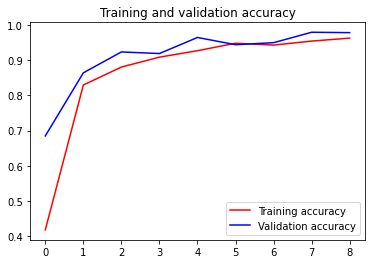

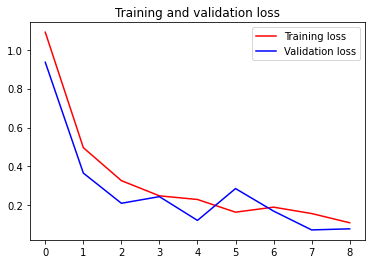

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
acc = iterate_model.history['accuracy']
val_acc = iterate_model.history['val_accuracy']
loss = iterate_model.history['loss']
val_loss = iterate_model.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

Saving scissors.png to scissors (2).png
Saving rock.png to rock (2).png
Saving paper.png to paper (2).png
scissors.png
[[0. 0. 1.]]
scissors
rock.png
[[0. 1. 0.]]
rock
paper.png
[[1. 0. 0.]]
paper


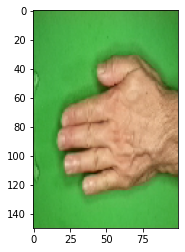

In [17]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  path = fn
  img = image.load_img(path, target_size=(150, 100))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(fn)
  print(classes)
  if classes[0][0]:
    print("paper")
  elif classes[0][1]:
    print("rock")
  else:
    print("scissors")